Facial Keypoint Detection

Based on paper [Facial Key Points Detection using Deep Convolutional Neural Network](https://arxiv.org/pdf/1710.00977.pdf)

Goals:

1) To train a Neural Network to identify facial landmarks from an image of a face
2) Create a pipline to use Haar Cascades to locate faces in an arbitrary image so facial landmarks can be found and plotted
3) Implememt this pipleline in a web app so that facial keypoints may be detected from a live webcam feed 

Exploritory Data Analysis

the dataset that will be used to train the network has been extracted from the [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/) and has been processed to identify 68 unique facial keypoints on each image.

Below I visualize some of the training set.

In [3]:
# !bash get_dataset.sh

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from PIL import Image
import random
import cv2

In [5]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

key_pts_frame.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


Looking at the first couple of rows, it appears that frames_keypoints.csv holds annotations for the keypoint coordinates and the file name.

After a bit of digging, I found that each adjacent group of two floats represent the x and y coordinates of the 68 facial keypoints; below I group them together into tuples using `reshape(-1, 2)`

In [6]:
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Number of images: ', key_pts_frame.shape[0])
print('Image name: ', image_name)
print('First 4 key pts: {}'.format(key_pts[:4]))

Number of images:  3462
Image name:  Luis_Fonsi_21.jpg
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


One thing to note is that the images come in many sizes and the landmark points are relitive to the size of these images, so they will need to be standardized before used for training

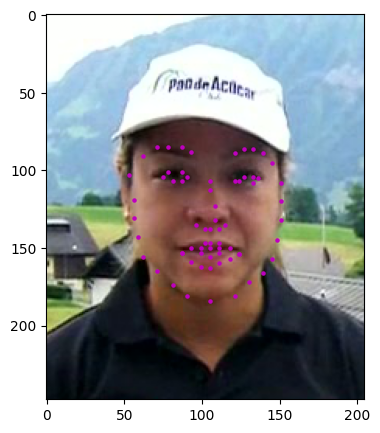

In [7]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

n = random.randint(0, key_pts_frame.shape[0])
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

To reduce the dimensionality of the input I will be converting the images to grayscale

keypoints will be scaled between -1 and 1 while pixel data will be scaled between 0 and 1

for image augmentation I will be preforming a randomly sized center crop

In [86]:
def dataGenerator(annotations_path, images_path, input_size, batch_size, shuffle):
  annotations = pd.read_csv(annotations_path).to_numpy()
  while True:
    if shuffle:
      np.random.shuffle(annotations)

    X_batch = []
    y_batch = []

    for annotation in annotations:
      image_filename = annotation[0]
      keypoints = annotation[1:].astype('float').reshape(-1, 2)

      X = Image.open(f'{images_path}/{image_filename}')
      X = np.array(X)
      width, height = X.shape[:2]

      # if image has an alpha color channel, remove it
      if(X.shape[2] == 4):
          X = X[:,:,0:3]

      X = color_jitter(X)
      
      X = cv2.resize(X, input_size)
      X = np.array(cv2.cvtColor(X, cv2.COLOR_RGB2GRAY))
      # normalize pixel values between 0 and 1
      X = X / 255.0

      # normalize keypoint coordinates between -1 and 1
      y = (keypoints / [height/2, width/2] - 1).flatten()

      X, y = random_center_crop(X, y, (1., 0.5))
      X, y = random_horizontal_flip(X, y)

      X_batch.append(X)
      y_batch.append(y)

      if len(X_batch) == batch_size:
        yield np.array(X_batch), np.array(y_batch)
        X_batch = []
        y_batch = []

def color_jitter(X, brightness_range=(-50,50), saturate_range=(-50,50)):
  brighten = int(random.randrange(*brightness_range))
  saturate = int(random.randrange(*saturate_range))
  hsv = cv2.cvtColor(X, cv2.COLOR_RGB2HSV)
  h, s, v = cv2.split(hsv)
  v = np.array(v) + brighten
  v = v.clip(0, 255).astype(h.dtype)
  s = np.array(s) + saturate
  s = s.clip(0, 255).astype(h.dtype)
  final_hsv =  cv2.merge((h, s, v))
  return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)

def random_center_crop(X, y, scale_range):
  original_dim = X.shape[0]
  scale_factor = random.uniform(*scale_range)
  new_dim = int(original_dim * scale_factor)
  offset = int((original_dim - new_dim) / 2)
  cropped_X = X[offset:offset+new_dim, offset:offset+new_dim]
  cropped_X = np.array(cv2.resize(cropped_X, (original_dim, original_dim)))
  cropped_y = (y / (scale_factor)).clip(min=-0.99, max=0.99)
  return cropped_X, cropped_y

def random_horizontal_flip(X, y, percent=50):
  flipped_X = X
  flipped_y = y
  if random.randrange(0, 100) > percent:
    flipped_X = np.array(cv2.flip(X, 1))
    flipped_y = (y.reshape(-1, 2) * [-1 ,1]).flatten()
  return flipped_X, flipped_y

  
def to_tf_dataset(data_gen, batch_size, img_size, output_size):

  def gen():
    for X_batch, y_batch in data_gen:
      yield X_batch, y_batch

  return tf.data.Dataset.from_generator(
     gen,
     output_signature=(
        tf.TensorSpec(shape=(batch_size,*img_size), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size,*output_size), dtype=tf.float32))
    ).prefetch(1)

Here we use the dataset helper functions defined above to create a data generator that processes the images and landmark annotations

In [87]:
train_gen = dataGenerator('data/training_frames_keypoints.csv', 'data/training', (224,224), 1, True)

train_ds = to_tf_dataset(train_gen, 1, (224,224), (136,))

and here is one sample image after processing

X shape (224, 224)
y shape (136,)


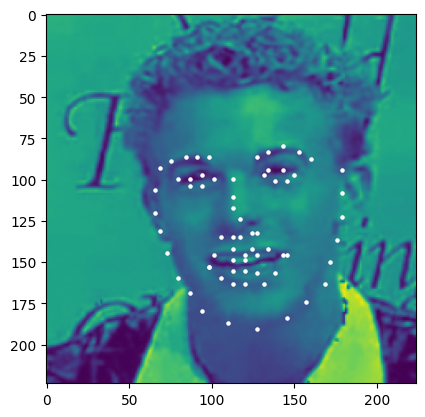

In [88]:
X_batch, y_batch = next(train_ds.take(1).as_numpy_iterator())
print('X shape', X_batch[0].shape)
print('y shape', y_batch[0].shape)

plt.imshow(X_batch[0])
key_pts = ((y_batch[0] + 1) * 112).reshape(-1, 2)
plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='w')
plt.show()
